# Welcome to GoNB

[*GoNB*](https://github.com/janpfeifer/gonb) is a *Go* notebook kernel. It allows one to easily run *Go* code in a *Jupyter Notebook* and variations.

In this tutorial we will walk through most of its features, and explain how it works.

See the [README.md's Installation section](https://github.com/janpfeifer/gonb#installation). It also includes a Docker with Jupyter+GoNB pre-installed, that makes it trivial.

## Hello World!

Whenever a cell is executed, *gonb* saves the cell content of the cell to a *Go* file, auto-imports missing dependencies (when it can guess), compiles and runs it. It may seem a lot, but its pretty fast (except
maybe the first cell run that is usually a little slower) and feels interactive. 

In [1]:
func main() {
    fmt.Printf("Hello World!")
}

Hello World!

Easy, right ? Now when trying different things, to avoid having to write `func main()` at every cell, *gonb* provides a short cut: "%%". Anything after a "%%" will be wrapped inside a `func main() { ... }`.

So, let's redo our example above:

In [2]:
%%
fmt.Printf("Hello World!")

Hello World!

## Globals and Updates

Imports, functions, constants, types and variables global declarations are memorized once executed, and carry over from one cell to another.

So one can work on different functions let's say on different cells.

Let's test it out:

In [3]:
func incr[T interface{constraints.Float|constraints.Integer}](x T) T {
    return x+T(1)
}

Ok, now we have `incr` defined to any numeric type, we can use it in all our future cells.

Some quick tests:

In [4]:
%%
x := incr(1)
y := incr(math.Pi)
fmt.Printf("incr: x=%d, y=%f\n", x, y)

incr: x=2, y=4.141593


> **Note**: Only the various declarations are carried over from one cell to another, not the results of the execution, including updates to variables.
> 
> So for instance, if we initialize a variable `startValue` with 1, then increment it in one cell. Next time we execute a new cell, it will be again initialized to 1. 

In [5]:
var startValue = float32(1)

%%
startValue = incr(startValue)
fmt.Printf("current startValue=%f\n", startValue)

current startValue=2.000000


Now if we execute again, `startValue` is again initialized to 1:

In [6]:
%%
fmt.Printf("current startValue=%f\n", startValue)

current startValue=1.000000


If one wants to save results calculated from one cell to another, GoNB includes the `github.com/janpfeifer/gonb/cache` package that makes it trivial to save and load previously generated results.

**Example**: Below `VeryExpensive` is only called once for `CachedValue`, so you will notice that if you run the cell multiple times, it will display always the same number, while `NonCachedValue` will always call `VeryExpensive` again, and display another number. So the string "...calculating..." is printed twice only the first time.

In [7]:
// Temporary fix until new release v0.6.0 propagates.
import (
    "math/rand"
    "github.com/janpfeifer/gonb/cache"
)

func VeryExpensive() int {
    fmt.Println("\t...VeryExpensive() call...")
    return rand.Intn(1000)
}

var (
    CachedValue = cache.Cache("expensive", VeryExpensive)
    NonCachedValue = VeryExpensive()
)
    
%%
fmt.Printf("NonCachedValue=%d\n", NonCachedValue)
fmt.Printf("   CachedValue=%d\n", CachedValue)

	...VeryExpensive() call...
	...VeryExpensive() call...
NonCachedValue=334
   CachedValue=751


The `cache` package has many more features, check out [its documentation](https://pkg.go.dev/github.com/janpfeifer/gonb/cache).

In [8]:
// Let's reset NonCachedValue so that it is not called again in the following cells.
var NonCachedValue = 0

## Imports

A few things to remember from imports in *gonb*:

* Like all other global declarations, they are memorized and carry over from one cell to the other. Still it's good practice to have each cell import what it needs -- no harm in importing the same thing multiple times.
* *gonb* runs *goimports* before compiling the code: that means it will be able to automatically add import statements for builtin packages (in the examples above we never wrote `import "fmt"`, and it just worked).
* *gonb* runs `go get` before compiling the code. This automatically fetches an external import dependency. That is convenient in most cases, but in case you want to get an external *Go* module at an specific version, you can do it manually with something like `!*go get <github.com/user/my_go_module>@<my_version>`. See below on running shell commands.

Let's create a simple example that imports a delighful progress-bar library. Notice it automatically fetches the lastest version of the library `github.com/schollz/progressbar/v3` -- and the execution of the cell the first time may take a few seconds because of that.


In [9]:
import progressbar "github.com/schollz/progressbar/v3"

%%
bar := progressbar.NewOptions(100, 
                              progressbar.OptionUseANSICodes(true),
                              progressbar.OptionShowIts(),
                              progressbar.OptionSetItsString("steps"))
for i := 0; i < 100; i++ {
    bar.Add(1)
    time.Sleep(40 * time.Millisecond)
}
fmt.Printf("\nDone\n")

 100% |████████████████████████████████████████| (25 steps/s) [3s:0s]:0s]
Done


## Displaying HTML, Image and others

One of the things that makes working in Notebooks better than using a terminal is that one can display rich content, like dynamically generated images, plots, HTML, even videos and sound.

We'll follow with a few examples of what is already supported.

### Improved Hello World!

*gonb* includes the accompanying library *gonbUI* that handles the interfacing to the Notebook through a very simple API:


In [10]:
import "github.com/janpfeifer/gonb/gonbui"

%%
gonbui.DisplayHTML(`<span style="background:pink; color:#111; border-radius: 3px; border: 3px solid orange; font-size: 18px;">I 🧡 GoNB!</span>`)

I 🧡 GoNB!

### Fractals

Let's draw a fractal, using another fun package: [github.com/benc-uk/gofract]("github.com/benc-uk/gofract")

lastRenderTime=1.633473


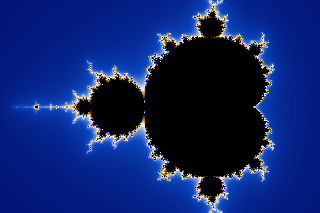

In [11]:
import "github.com/benc-uk/gofract/pkg/fractals"
import "github.com/benc-uk/gofract/pkg/colors"

%%
imgWidth := 320

// Default fractal
f := fractals.Fractal{
    FractType:    "mandelbrot",
    Center:       fractals.ComplexPair{-0.6, 0.0},
    MagFactor:    1.0,
    MaxIter:      90,
    W:            3.0,
    H:            2.0,
    ImgWidth:     imgWidth,
    JuliaSeed:    fractals.ComplexPair{0.355, 0.355},
    InnerColor:   "#000000",
    FullScreen:   false,
    ColorRepeats: 2,
}
gradient := colors.GradientTable{}
gradient.AddToTable("#000762", 0.0)
gradient.AddToTable("#0B48C3", 0.2)
gradient.AddToTable("#ffffff", 0.4)
gradient.AddToTable("#E3A000", 0.5)
gradient.AddToTable("#000762", 0.9)
imgHeight := int(float64(imgWidth) * float64(f.H/f.W))
img := image.NewRGBA(image.Rect(0, 0, f.ImgWidth, imgHeight))
lastRenderTime := f.Render(img, gradient)
fmt.Printf("lastRenderTime=%v\n", lastRenderTime)
gonbui.DisplayImage(img)


### SVG Drawing

From the amazing [SVGo library](https://github.com/ajstarks/svgo), I really wish I was that creative.
Below is Antony Stark's Shining example, [demoed here](https://speakerdeck.com/ajstarks/svgo-code-plus-picture-examples)

In [12]:
import "bytes"
import svgo "github.com/ajstarks/svgo"
import "github.com/janpfeifer/gonb/gonbui"

func Shining(width, height int) string {
    buf := bytes.NewBuffer(nil)
    canvas := svgo.New(buf)
    xp := []int{50, 70, 70, 50, 30, 30}
    yp := []int{40, 50, 75, 85, 75, 50}
    xl := []int{0, 0, 50, 100, 100}
    yl := []int{100, 40, 10, 40, 100}
    bgcolor := "rgb(227,78,25)"
    bkcolor := "rgb(153,29,40)"
    stcolor := "rgb(65,52,44)"
    stwidth := 12
    stylefmt := "stroke:%s;stroke-width:%d;fill:%s"
    canvas.Start(width, height)
    canvas.Def()
    canvas.Gid("unit")
    canvas.Polyline(xl, yl, "fill:none")
    canvas.Polygon(xp, yp)
    canvas.Gend()
    canvas.Gid("runit")
    canvas.TranslateRotate(150, 180, 180)
    canvas.Use(0, 0, "#unit")
    canvas.Gend()
    canvas.Gend()
    canvas.DefEnd()
    canvas.Rect(0, 0, width, height, "fill:"+bgcolor)
    canvas.Gstyle(fmt.Sprintf(stylefmt, stcolor, stwidth, bkcolor))
    for y := 0; y < height; y += 130 {
        for x := -50; x < width; x += 100 {
            canvas.Use(x, y, "#unit")
            canvas.Use(x, y, "#runit")
        }
    } 
    canvas.Gend()
    canvas.End()
    return buf.String()
}

%%
gonbui.DisplaySVG(Shining(500, 500))

<?xml version="1.0"?>
<!-- Generated by SVGo -->

### Plotting with [Margaid (SVG)](https://github.com/erkkah/margaid)

A real pearl!

Since its latest update is not yet "released" (tagged in Git), we needed to get the version on the specific commit. See "Executing Shell Commands" below.

In [13]:
!*go get -u github.com/erkkah/margaid@d60b2efd2f5acc5d8fbbe13eaf85f1532e11a2fb

go: added github.com/erkkah/margaid v0.1.1-0.20230128143048-d60b2efd2f5a


In [14]:
import "bytes"
import "github.com/janpfeifer/gonb/gonbui"
import mg "github.com/erkkah/margaid"

func mgPlot(width, height int) string {
    randomSeries := mg.NewSeries()
    rand.Seed(time.Now().Unix())
    for i := float64(0); i < 10; i++ {
        randomSeries.Add(mg.MakeValue(i+1, 200*rand.Float64()))
    }

    testSeries := mg.NewSeries()
    multiplier := 2.1
    v := 0.33
    for i := float64(0); i < 10; i++ {
        v *= multiplier
        testSeries.Add(mg.MakeValue(i+1, v))
    }

    diagram := mg.New(width, height,
        mg.WithAutorange(mg.XAxis, testSeries),
        mg.WithAutorange(mg.YAxis, testSeries),
        mg.WithAutorange(mg.Y2Axis, testSeries),
        mg.WithProjection(mg.YAxis, mg.Log),
        mg.WithInset(70),
        mg.WithPadding(2),
        mg.WithColorScheme(90),
        mg.WithBackgroundColor("#f8f8f8"),
    )

    diagram.Line(testSeries, mg.UsingAxes(mg.XAxis, mg.YAxis), mg.UsingMarker("square"), mg.UsingStrokeWidth(1))
    diagram.Smooth(testSeries, mg.UsingAxes(mg.XAxis, mg.Y2Axis), mg.UsingStrokeWidth(3.14))
    diagram.Smooth(randomSeries, mg.UsingAxes(mg.XAxis, mg.YAxis), mg.UsingMarker("filled-circle"))
    diagram.Axis(testSeries, mg.XAxis, diagram.ValueTicker('f', 0, 10), false, "X")
    diagram.Axis(testSeries, mg.YAxis, diagram.ValueTicker('f', 1, 2), true, "Y")

    diagram.Frame()
    diagram.Title("A diagram of sorts 📊 📈")
    buf := bytes.NewBuffer(nil)
    diagram.Render(buf)
    return buf.String()
}

%%
gonbui.DisplaySVG(mgPlot(640, 480))

<path vector-effect="non-scaling-stroke" d="M1.000000e+01,6.800000e+00 C1.888889e+01,6.875434e+00 4.555556e+01,7.018758e+00 6.333333e+01,7.252602e+00 C8.111111e+01,7.486446e+00 9.888889e+01,7.711993e+00 1.166667e+02,8.203066e+00 C1.344444e+02,8.694139e+00 1.522222e+02,9.167786e+00 1.700000e+02,1.019904e+01 C1.877778e+02,1.123029e+01 2.055556e+02,1.222495e+01 2.233333e+02,1.439059e+01 C2.411111e+02,1.655622e+01 2.588889e+02,1.864500e+01 2.766667e+02,2.319283e+01 C2.944444e+02,2.774066e+01 3.122222e+02,3.212711e+01 3.300000e+02,4.167755e+01 C3.477778e+02,5.122798e+01 3.655556e+02,6.043953e+01 3.833333e+02,8.049545e+01 C4.011111e+02,1.005514e+02 4.188889e+02,1.198956e+02 4.366667e+02,1.620130e+02 C4.544444e+02,2.041305e+02 4.811111e+02,3.046688e+02 4.900000e+02,3.332000e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.000000e+01,2.311058e+02 C1.888889e+01,2.395117e+02 4.555556e+01,2.930900e+02 6.333333e+01,2.815410e+02 C8.111111e+01,2.699919e+02 9.888889e+01,1.652558e+02 1.166667e+02,1.618115e+02 C1.344444e+02,1.583672e+02 1.522222e+02,2.464390e+02 1.700000e+02,2.608752e+02 C1.877778e+02,2.753114e+02 2.055556e+02,2.461016e+02 2.233333e+02,2.484287e+02 C2.411111e+02,2.507559e+02 2.588889e+02,2.730779e+02 2.766667e+02,2.748379e+02 C2.944444e+02,2.765980e+02 3.122222e+02,2.606821e+02 3.300000e+02,2.589888e+02 C3.477778e+02,2.572955e+02 3.655556e+02,2.638599e+02 3.833333e+02,2.646782e+02 C4.011111e+02,2.654965e+02 4.188889e+02,2.622838e+02 4.366667e+02,2.638986e+02 C4.544444e+02,2.655133e+02 4.811111e+02,2.726220e+02 4.900000e+02,2.743666e+02 "/> 1 2 3 4 5 6 7 8 9 10 X 1.0 2.0 4.0 8.0 16.0 32.0 64.0 128.0 256.0 512.0 Y A diagram of sorts 📊 📈

### Animated Plots with `UpdateHTML`

Still using Margaid but now we animate a `Sin(x)` plot varying the frequency from 0.0 to 10.0, every 10 milliseconds. This demonstrates `gonbui.UpdateHTML(id, html)`: it allows a transient HTML cell to be updated in the middle of the execution of a cell.

In [15]:
import (
    "bytes"
    "math"
    "time"
    
     "github.com/janpfeifer/gonb/gonbui"
     mg "github.com/erkkah/margaid"
)


func mgSinPlot(width, height int, freq float64) string {
    series := mg.NewSeries()
    const numPoints = 100
    for i := 0; i < numPoints; i++ {
        x := float64(i) / float64(numPoints) * 2.0 * math.Pi * freq
        series.Add(mg.MakeValue(x, math.Sin(x)))
    }
    diagram := mg.New(width, height,
        mg.WithAutorange(mg.XAxis, series),
        mg.WithAutorange(mg.YAxis, series),
        mg.WithBackgroundColor("#f8f8f8"),
    )
    diagram.Smooth(series, mg.UsingAxes(mg.XAxis, mg.YAxis), mg.UsingStrokeWidth(3.14))
    diagram.Frame()
    diagram.Title("Animated Sine")
    buf := bytes.NewBuffer(nil)
    diagram.Render(buf)
    return buf.String()
}

%%
htmlCellID := gonbui.UniqueID()
plotSVG := ""
ticker := time.NewTicker(10 * time.Millisecond)
for freq := 0.0; freq <= 10.0; freq += 0.005 {
    plotSVG = mgSinPlot(1024, 400, freq)
    gonbui.UpdateHTML(htmlCellID, plotSVG)
    <-ticker.C
}
ticker.Stop()

// Erase transient and display final image.
gonbui.UpdateHTML(htmlCellID, "")
gonbui.DisplayHTML(plotSVG)


<path vector-effect="non-scaling-stroke" d="M0.000000e+00,1.360312e+02 C1.508418e+00,1.499049e+02 6.033670e+00,1.968203e+02 9.050505e+00,2.192736e+02 C1.206734e+01,2.417269e+02 1.508418e+01,2.621600e+02 1.810101e+01,2.707510e+02 C2.111785e+01,2.793420e+02 2.413468e+01,2.793693e+02 2.715152e+01,2.708197e+02 C3.016835e+01,2.622702e+02 3.318519e+01,2.418813e+02 3.620202e+01,2.194536e+02 C3.921886e+01,1.970259e+02 4.223569e+01,1.640012e+02 4.525253e+01,1.362537e+02 C4.826936e+01,1.085063e+02 5.128620e+01,7.544786e+01 5.430303e+01,5.296898e+01 C5.731987e+01,3.049010e+01 6.033670e+01,1.001293e+01 6.335354e+01,1.380483e+00 C6.637037e+01,-7.251970e+00 6.938721e+01,-7.333825e+00 7.240404e+01,1.174264e+00 C7.542088e+01,9.682353e+00 7.843771e+01,3.002705e+01 8.145455e+01,5.242902e+01 C8.447138e+01,7.483099e+01 8.748822e+01,1.078388e+02 9.050505e+01,1.355861e+02 C9.352189e+01,1.633334e+02 9.653872e+01,1.964086e+02 9.955556e+01,2.189130e+02 C1.025724e+02,2.414174e+02 1.055892e+02,2.619386e+02 1.086061e+02,2.706125e+02 C1.116229e+02,2.792864e+02 1.146397e+02,2.794228e+02 1.176566e+02,2.709562e+02 C1.206734e+02,2.624896e+02 1.236902e+02,2.421892e+02 1.267071e+02,2.198130e+02 C1.297239e+02,1.974367e+02 1.327407e+02,1.644460e+02 1.357576e+02,1.366989e+02 C1.387744e+02,1.089517e+02 1.417912e+02,7.585985e+01 1.448081e+02,5.332998e+01 C1.478249e+02,3.080011e+01 1.508418e+02,1.023488e+01 1.538586e+02,1.519623e+00 C1.568754e+02,-7.195632e+00 1.598923e+02,-7.386626e+00 1.629091e+02,1.038449e+00 C1.659259e+02,9.463524e+00 1.689428e+02,2.971965e+01 1.719596e+02,5.207007e+01 C1.749764e+02,7.442050e+01 1.779933e+02,1.073941e+02 1.810101e+02,1.351410e+02 C1.840269e+02,1.628879e+02 1.870438e+02,1.959963e+02 1.900606e+02,2.185516e+02 C1.930774e+02,2.411069e+02 1.960943e+02,2.617161e+02 1.991111e+02,2.704727e+02 C2.021279e+02,2.792293e+02 2.051448e+02,2.794749e+02 2.081616e+02,2.710914e+02 C2.111785e+02,2.627078e+02 2.141953e+02,2.424960e+02 2.172121e+02,2.201715e+02 C2.202290e+02,1.978469e+02 2.232458e+02,1.648906e+02 2.262626e+02,1.371440e+02 C2.292795e+02,1.093973e+02 2.322963e+02,7.627244e+01 2.353131e+02,5.369180e+01 C2.383300e+02,3.111115e+01 2.413468e+02,1.045806e+01 2.443636e+02,1.660091e+00 C2.473805e+02,-7.137881e+00 2.503973e+02,-7.438012e+00 2.534141e+02,9.039661e-01 C2.564310e+02,9.245944e+00 2.594478e+02,2.941330e+01 2.624646e+02,5.171196e+01 C2.654815e+02,7.401061e+01 2.684983e+02,1.069497e+02 2.715152e+02,1.346959e+02 C2.745320e+02,1.624421e+02 2.775488e+02,1.955834e+02 2.805657e+02,2.181894e+02 C2.835825e+02,2.407953e+02 2.865993e+02,2.614923e+02 2.896162e+02,2.703316e+02 C2.926330e+02,2.791709e+02 2.956498e+02,2.795256e+02 2.986667e+02,2.712252e+02 C3.016835e+02,2.629248e+02 3.047003e+02,2.428019e+02 3.077172e+02,2.205292e+02 C3.107340e+02,1.982565e+02 3.137508e+02,1.653348e+02 3.167677e+02,1.375890e+02 C3.197845e+02,1.098432e+02 3.228013e+02,7.668562e+01 3.258182e+02,5.405442e+01 C3.288350e+02,3.142323e+01 3.318519e+02,1.068249e+01 3.348687e+02,1.801885e+00 C3.378855e+02,-7.078717e+00 3.409024e+02,-7.487981e+00 3.439192e+02,7.708167e-01 C3.469360e+02,9.029615e+00 3.499529e+02,2.910801e+01 3.529697e+02,5.135467e+01 C3.559865e+02,7.360134e+01 3.590034e+02,1.065055e+02 3.620202e+02,1.342508e+02 C3.650370e+02,1.619961e+02 3.680539e+02,1.951700e+02 3.710707e+02,2.178263e+02 C3.740875e+02,2.404827e+02 3.771044e+02,2.612672e+02 3.801212e+02,2.701891e+02 C3.831380e+02,2.791110e+02 3.861549e+02,2.795748e+02 3.891717e+02,2.713576e+02 C3.921886e+02,2.631405e+02 3.952054e+02,2.431066e+02 3.982222e+02,2.208860e+02 C4.012391e+02,1.986655e+02 4.042559e+02,1.657788e+02 4.072727e+02,1.380341e+02 C4.102896e+02,1.102894e+02 4.133064e+02,7.709938e+01 4.163232e+02,5.441786e+01 C4.193401e+02,3.173635e+01 4.223569e+02,1.090815e+01 4.253737e+02,1.945003e+00 C4.283906e+02,-7.018140e+00 4.314074e+02,-7.536535e+00 4.344242e+02,6.390024e-01 C4.374411e+02,8.814539e+00 4.404579e+02,2.880377e+01 4.434747e+02,5.099823e+01 C4.464916e+02,7.319268e+01 4.495084e+02,1.060617

### Plotting with [Gonum Plot](https://github.com/gonum/plot) (SVG and PNG)

Another great plotting library.

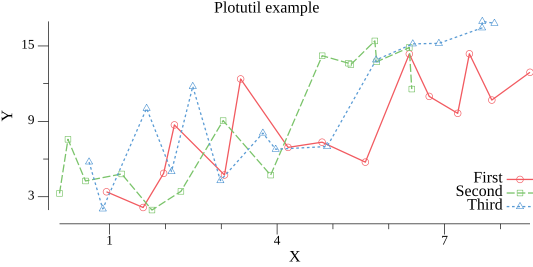

In [16]:
import (
    "bytes"
    "math/rand"

    "github.com/janpfeifer/gonb/gonbui"
    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/plotutil"
    "gonum.org/v1/plot/vg"
)

// randomPoints returns some random x, y points.
func randomPoints(n int) plotter.XYs {
    pts := make(plotter.XYs, n)
    for i := range pts {
        if i == 0 {
            pts[i].X = rand.Float64()
        } else {
            pts[i].X = pts[i-1].X + rand.Float64()
        }
        pts[i].Y = pts[i].X + 10*rand.Float64()
    }
    return pts
}

func GonumPlotExample(width, height int, format string) []byte {
    rand.Seed(int64(0))

    p := plot.New()

    p.Title.Text = "Plotutil example"
    p.X.Label.Text = "X"
    p.Y.Label.Text = "Y"

    err := plotutil.AddLinePoints(p,
        "First", randomPoints(15),
        "Second", randomPoints(15),
        "Third", randomPoints(15))
    if err != nil {
        panic(err)
    }
    
    buf := bytes.NewBuffer(nil)
    writerTo, err := p.WriterTo(vg.Points(float64(width)), vg.Points(float64(height)), format)
    if err != nil {
        panic(err)
    }
    writerTo.WriteTo(buf)
    return buf.Bytes()
}

%%
gonbui.DisplayPNG(GonumPlotExample(400, 200, "png"))

The version in SVG looks better though:

In [17]:
%%
gonbui.DisplaySVG(string(GonumPlotExample(400, 200, "svg")))

<?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 Plotutil example 
 X 
 1 
 4 
 7 
 
 
 
 
 
 
 
 
 
 
 Y 
 
 3 
 9 
 15 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 First 
 
 
 Second 
 
 
 Third

### Desktop App Development with Fyne

If using a Jupyter-Lab ran with access to X11, one can also experiment with desktop UI programs. Let's try the [*Hello World*](https://developer.fyne.io/started/hello) from [Fyne](https://fyne.io/), a popular, high quality graphical application toolkit for Go.

> **Important Note**: Disabled by default: since this have many requirements, and won't run in a test environment. But feel free to
> copy&paste the code to a new cell and run it!

> **Note 1**: Fyne needs to link many C++ libraries, so the firt time this is used it takes a few minutes to compile everything. But
> afterwards it becomes immediate and interactive.

> **Note 2**: To compile it it requires some libraries present in the system. See [Fyne's Getting Started](https://developer.fyne.io/started/).

> **Note 3**: Remember to close the newly created small "Hello World!" window: GoNB is blocking while running a cell, and the cell only finishes to execute when the window is closed. Here we add a timeout just in case.

```go
import (
    "log"
    "time"

    "fyne.io/fyne/v2/app"
    "fyne.io/fyne/v2/widget"
)

%%
a := app.New()
w := a.NewWindow("Hello World")
go func() {
    <- time.Tick(10 * time.Second)
    log.Printf("Timed out, exiting...")
    os.Exit(1)
}()

w.SetContent(widget.NewLabel("Hello World!"))
w.ShowAndRun()
fmt.Println("Goodbye!")
```


### User Input

There are different way to provide input to a program in GoNB. We list them below and introduce a new one:

1. Simply define constants or variables in the cell and use them. The cell itself is a good way to enter input.
2. Add flags, and pass the values of flags after the `%%` command. For instance `%% --x=10` will run your cell with the flag `x` set to 10. This is handy for instance to test a function with different values, each one in a different cell.
3. Read the input from an external file. One can edit the file in Jupyter or another text editor. It's easy to set `os.Stdin` to the desired file.
4. Jupyter Notebooks provide a form of input request, where it displays an in-place text box. The `gonbui` package has a function to do that, the results of which can be read in from the `stdin` afterwards. See the following example:

```go
import (
    "fmt"
    "github.com/janpfeifer/gonb/gonbui"
)

%%
gonbui.RequestInput("Tell me a number: ", false)
var x int
_, err := fmt.Scan(&x)
if err != nil { panic(err) }
fmt.Printf("The number you typed was %d\n", x)

gonbui.RequestInput("Tell me a secret: ", true)
var secret string
_, err = fmt.Scan(&secret)
if err != nil { panic(err) }
fmt.Printf("Shh! Your secret was %q\n", secret)
```

The output would be something like:

```
Tell me a number:  42
The number you typed was 42
Tell me a secret:  ······
Shh! Your secret was "I🧡GoNB!"
```

> **Note**: Not executed by default because it breaks the automatic tests, but try it out on a new cell!

## Flags

The `%%` command can also be used to set arguments to the execution of the cell. This makes it easy to configure 
different runs of the same code using flags. This is something handy when testing or developing code that is shared
with a normal code that already used flags.

Also,`%%` not only wraps the code following it in a `func main() { ... }` but also automatically adds a call to `flag.Parse()`. 

Example:

In [18]:
import (
    "flag"
    "fmt"
)

var flagWho = flag.String("who", "", "Your name!")

%% --who=world
fmt.Printf("Hello %s!\n", *flagWho)

Hello world!


Alternatively one can also set the arguments for execution with `%args`, if not using `%%`, as in:

In [19]:
%args --who=Wally

func main() {
    flag.Parse()
    fmt.Printf("Where is %s?", *flagWho)
}

Where is Wally?

## Executing Shell Commands

There are two variations to execute shell commands. They differ only on the directory
from where they are executed.

* `!` prefix executes what comes next should be executed as a shell command, on the same directory
  where the kernel is executed -- typically the same directory where the notebook files is saved.


In [20]:
!go version
!pwd ; ls -l

go version go1.20.5 linux/amd64
/home/janpf/Projects/gonb/examples
total 428
-rw-r--r-- 1 janpf janpf 158378 Mar  8 07:18 experimental.ipynb
-rwxr-xr-x 1 janpf janpf  87160 May 22 11:29 google_colab_demo.ipynb
-rw-r--r-- 1 janpf janpf 185777 Jul 20 09:14 tutorial.ipynb


* `!*` prefix executes what comes next as a shell command, on the temporary directory used 
  to compile the *Go* program when executing the cells. This includes the `go.mod` file, that
  can be manipulated for special use cases, like importing a specific version of a module, 
  or to `redirect` a module to a local directory for development (see `Replace` section below)
  
Example:

In [21]:
!*pwd ; ls -l

/tmp/gonb_036046a6
total 9296
-rw-r--r-- 1 janpf janpf    1202 Jul 20 09:15 go.mod
-rwxr-xr-x 1 janpf janpf 9491670 Jul 20 09:15 gonb_036046a6
prw------- 1 janpf janpf       0 Jul 20 09:15 gonb_pipe_3304903318
srwxr-xr-x 1 janpf janpf       0 Jul 20 09:14 gopls_socket
-rw-r--r-- 1 janpf janpf   10229 Jul 20 09:15 go.sum
-rw-r--r-- 1 janpf janpf    4819 Jul 20 09:15 main.go


You can also use a `\` at the end of the line to extend the shell command to multiple lines.

Example:

In [22]:
!((ii=0)) ;\
while ((ii < 5)) ; do \
  printf "\rCounting: ${ii} ..." ;\
  sleep 1;\
  ((ii+=1));\
done;\
echo

Counting: 4 ...


If some shell program requires some input from the user, you can precede it with a `%with_inputs` or `%with_password` (for hidden input) and it will open a text field for typing some arbitrary text input. Example:

```shell
%with_password
!sudo -S apt update
```

## Environment Variables

For convenience, **GoNB** defines the following environment variables -- available for the shell scripts (`!` and `!*`) and for the _Go_ cells:

* `GONB_DIR`: the directory where commands are executed from. This can be changed with `%cd`.
* `GONB_TMP_DIR`: the directory where the temporary Go code, with the cell code, is stored and compiled. This is the directory where `!*` scripts are executed. It only changes when a kernel is restarted, and a new temporary directory is created.
* `GONB_PIPE`: is the _named pipe_ directory used to communicate rich content (HTML, images) to the kernel. Only available for _Go_ cells, and a new one is created at every execution. This is used by the `gonbui` functions described above, and doesn't need to be accessed directly.

## Developing Go libraries with a notebook: `go.mod` and `go.work`

*GoNB* uses `go.mod` and understands `go.work` -- but won't create it by default.

### "Replace" modules in `go.mod`

Using the `!*` command above we can easily "replace" a module to a local directory. This can be very handy
for developing a library in a powerful IDE on the side, and using the *GoNB* notebook to execute tests
and experiments. Changes in the library (in the IDE) when saved immediate take effect on the next cell execution.


The accompaining library *gonbui* was implemented mostly in this fashion using a notebook, that started with:

```
!*go mod edit -replace github.com/janpfeifer/gonb=/home/janpf/Projects/gonb
```

Check out the results with:

```
!*cat go.mod
```

In [23]:
!*go mod edit -replace "github.com/janpfeifer/gonb=${HOME}/Projects/gonb"
!*cat go.mod

module gonb_036046a6

go 1.20

require (
	github.com/ajstarks/svgo v0.0.0-20211024235047-1546f124cd8b
	github.com/benc-uk/gofract v0.0.0-20230120162050-a6f644f92fd6
	github.com/erkkah/margaid v0.1.1-0.20230128143048-d60b2efd2f5a
	github.com/janpfeifer/gonb v0.7.3
	github.com/schollz/progressbar/v3 v3.13.1
	golang.org/x/exp v0.0.0-20230713183714-613f0c0eb8a1
	gonum.org/v1/plot v0.13.0
)

require (
	git.sr.ht/~sbinet/gg v0.4.1 // indirect
	github.com/go-fonts/liberation v0.3.1 // indirect
	github.com/go-latex/latex v0.0.0-20230307184459-12ec69307ad9 // indirect
	github.com/go-pdf/fpdf v0.8.0 // indirect
	github.com/gofrs/uuid v4.4.0+incompatible // indirect
	github.com/golang/freetype v0.0.0-20170609003504-e2365dfdc4a0 // indirect
	github.com/lucasb-eyer/go-colorful v1.0.3 // indirect
	github.com/mattn/go-runewidth v0.0.14 // indirect
	github.com/mitchellh/colorstring v0.0.0-20190213212951-d06e56a500db // indirect
	github.com/pkg/errors v0.9.1 // indirect
	github.com/rivo/uniseg v0.2.0 /

### "Use" modules in `go.work`

Another way to refer to modules that are being co-developed in local file is using [Go workspaces](https://go.dev/doc/tutorial/workspaces).
                                                                                                   
In **GoNB**, a convenient way to achive this is by first creating a `go.work` and then selecting the modules to be use from the local disk. Example:                                                                                           

In [24]:
!*rm -f go.work && go work init && go work use . "${HOME}/Projects/gonb"
%goworkfix

	- replace rule for module "github.com/janpfeifer/gonb" to local directory "/home/janpf/Projects/gonb" already exists.

> **Note**:
> - **GoNB** uses `go get` to automatically fetch missing imports.
>   Unfortunately `go get` doesn't handle `go.work` `use` definitions.
>   The special command `%goworkfix` handles that by adding a `replace` entry in `go.mod` for
>   all modules pointed to by `go.work`.
> - One can use the env variable `GONB_DIR` to refer to the current kernel directory (changed with `%cd`).

### Tracked directories

**GoNB** tracks for changes in local files in target directories of `replace` rules in `go.mod` or `use` rules in `go.work`. This way auto-complete and contextual help stay up-to-date with changes on local files you may be editing on a separate editor.

See `%track` and `%untrack` to list and control tracking. For instance, in our tutorial, this is what **GoNB** is tracking:

In [25]:
%track

List of files/directories being tracked: 
 
 /home/janpf/Projects/gonb 
 /home/janpf/Projects/gonb/cache 
 /home/janpf/Projects/gonb/common 
 /home/janpf/Projects/gonb/dispatcher 
 /home/janpf/Projects/gonb/goexec 
 /home/janpf/Projects/gonb/goexec/goplsclient 
 /home/janpf/Projects/gonb/gonbui 
 /home/janpf/Projects/gonb/gonbui/protocol 
 /home/janpf/Projects/gonb/kernel 
 /home/janpf/Projects/gonb/specialcmd

## More ... and Help

Some other features:

* **Errors reported** by the Go compiler are parsed and a **_mouse-over_ context is displayed**. This facilitates understanding the error, since the line numbers reported by Go are not the same as in the cell being executed.
* **Contextual Help**: can be activated with **"Shift+Tab""** (floating note) or **"Control+I"** (for a separate sub-window). Notice it may be slow if some new import needs to be fetched -- consider executing once some code with the imports before using the contextual help.

The library is new, and there is still development going on, with still some features in the pipeline (more on the displaying side, auto-complete). For those
who enjoy coding, help in improving *GoNB* is very welcome!

Finally, there is also the `%help` command, which lists all the currently supported features:

In [26]:
%help

GoNB is a Go kernel that compiles and executed on-the-fly Go code. 

When executing a cell, *GoNB* will save the cell contents (except non-Go commands see
below) into a "main.go" file, compile and execute it.

It also saves any global declarations (imports, functions, types, variables, constants)
and reuse them at the next cell execution -- so you can define a function in one
cell, and reuse in the next one. Just the "func main()" is not reused.

A "hello world" example would look like:

	func main() {
		fmt.Printf("Hello world!\n");
	}

But to avoid having to type "func main()" all the time, you can use "%%" and everything
after is wrapped inside a "func main() { ... }". So our revised "hello world" looks like:

	%%
	fmt.Printf("Hello world!\n")


- "init()" functions: since there is always only one definition per function name, 
  it's not possible for each cell to have it's own init() function. Instead GoNB
  converts any function named "init_<my_stuff>()" to "init()" before compili